<a href="https://colab.research.google.com/github/asjnhy/SMP-Prediction/blob/master/(200520)LightGBM_SMP_with_oil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 라이브러리 및 데이터

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import missingno as msno
import warnings
warnings.filterwarnings(action='ignore') 

In [0]:
os.chdir('/content/drive/My Drive/dacon_electricity_consumption')

In [0]:
weather = pd.read_csv('data_v2/weather_v2.csv')
target= pd.read_csv('data_v2/target_v2.csv')
oil = pd.read_csv('data_v2/oil_v2.csv')
# energy = pd.read_csv('data_v2/energy-prices.csv')

## 1-1. 데이터 target에 병합 

In [0]:
target = pd.merge(target,oil, how = 'outer')
target['Price_Mean'] = target['Price_Mean'].fillna(method = 'ffill')
target

,date,smp_max,smp_min,smp_mean,supply,Price_Mean
0,2018-02-01,150.65,116.84,132.71,87.47,67.393333
1,2018-02-02,163.86,116.84,134.19,86.64,66.590000
2,2018-02-03,164.07,116.85,131.39,88.28,66.590000
3,2018-02-04,171.00,115.76,131.89,86.14,66.590000
4,2018-02-05,170.34,123.89,137.96,90.63,65.586667
...,...,...,...,...,...,...
833,2020-05-14,193.28,66.78,100.46,62.70,28.083333
834,2020-05-15,198.23,61.81,102.38,64.91,28.083333
835,2020-05-16,220.91,88.50,121.19,61.75,28.083333
836,2020-05-17,207.75,65.78,116.82,61.55,28.083333


In [0]:
target['date'] = pd.to_datetime(target['date'])
target['year'] = target['date'].dt.year
target['month'] = target['date'].dt.month
target['day'] = target['date'].dt.day
target['dayofweek'] = target['date'].dt.dayofweek

In [0]:
weather = weather[weather['station'] == 'ASOS']
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.loc[:,'area':'temp']

weather_list = []
for area in weather['area'].unique():
    weather_list.append(weather[weather['area']==area].copy())
    
for i, area in enumerate(weather['area'].unique()):
    weather_list[i].drop(['area'], axis=1, inplace=True)
    weather_list[i].columns = ['datetime', str(area)+'_temp']

start = '2018-02-01'
end = '2020-05-18'
hourly_temperature = pd.DataFrame(columns = ['datetime'])
date_range = pd.date_range(start, end, freq='H')
hourly_temperature['datetime'] = date_range

for d in weather_list:
    hourly_temperature  = hourly_temperature.merge(d, how='outer')
hourly_temperature['median'] = hourly_temperature.median(axis=1)
hourly_temperature = hourly_temperature.loc[:,['datetime', 'median']]
hourly_temperature.columns = ['date', 'temperature']

hourly_temperature['temperature'][hourly_temperature['temperature'].isna()] = hourly_temperature.shift(-1)['temperature'][hourly_temperature['temperature'].isna()]

daily_temperature = pd.DataFrame(columns = ['date'])
date_range = pd.date_range(start, end, freq='D')
daily_temperature['date'] = date_range

for d in range(daily_temperature.shape[0]):
    for h in range(24):
        daily_temperature.loc[d, 'temp_h'+str(h)] = hourly_temperature['temperature'][d*24:d*24+24][d*24+h]

daily_temperature['temp_max'] = daily_temperature.loc[:,'temp_h0':].max(axis=1)
daily_temperature['temp_min'] = daily_temperature.loc[:,'temp_h0':].min(axis=1)
daily_temperature['temp_mean'] = daily_temperature.loc[:,'temp_h0':].mean(axis=1)

target['temp_max'] = daily_temperature['temp_max']
target['temp_min'] =daily_temperature['temp_min']
target['temp_mean'] = daily_temperature['temp_mean']


,date,smp_max,smp_min,smp_mean,supply,Price_Mean,year,month,day,dayofweek,temp_max,temp_min,temp_mean
0,2018-02-01,150.65,116.84,132.71,87.47,67.393333,2018,2,1,3,5.95,3.30,4.298077
1,2018-02-02,163.86,116.84,134.19,86.64,66.590000,2018,2,2,4,5.25,2.45,3.576923
2,2018-02-03,164.07,116.85,131.39,88.28,66.590000,2018,2,3,5,4.00,-0.50,1.457692
3,2018-02-04,171.00,115.76,131.89,86.14,66.590000,2018,2,4,6,0.30,-2.05,-1.000000
4,2018-02-05,170.34,123.89,137.96,90.63,65.586667,2018,2,5,0,2.05,-1.70,0.015385
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,2020-05-14,193.28,66.78,100.46,62.70,28.083333,2020,5,14,3,22.35,14.95,18.942308
834,2020-05-15,198.23,61.81,102.38,64.91,28.083333,2020,5,15,4,21.50,18.40,19.605769
835,2020-05-16,220.91,88.50,121.19,61.75,28.083333,2020,5,16,5,19.05,15.75,17.628846
836,2020-05-17,207.75,65.78,116.82,61.55,28.083333,2020,5,17,6,20.35,14.30,17.030769


In [0]:
# target.to_csv('target-with-features-v2.csv')

## 2. EDA

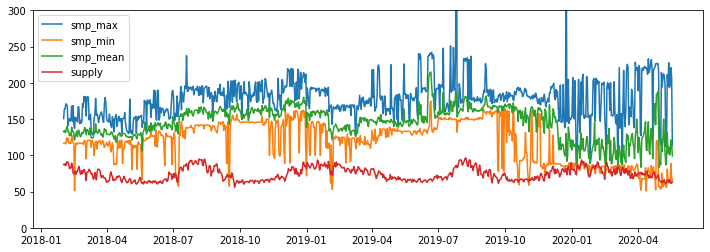

In [0]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_max'], label='smp_max')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_min'], label='smp_min')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_mean'], label='smp_mean')
plt.plot(target.loc[:, 'date'], target.loc[:, 'supply'], label='supply')
plt.ylim(0,300)
plt.legend()
plt.show()

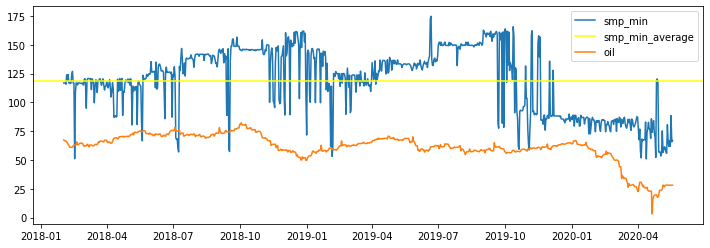

In [0]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_min'], label='smp_min')
plt.axhline(y = target['smp_min'].mean(), label = 'smp_min_average',color = 'yellow')
plt.plot(target.loc[:, 'date'], target.loc[:, 'Price_Mean'], label='oil')
plt.legend()
plt.show()

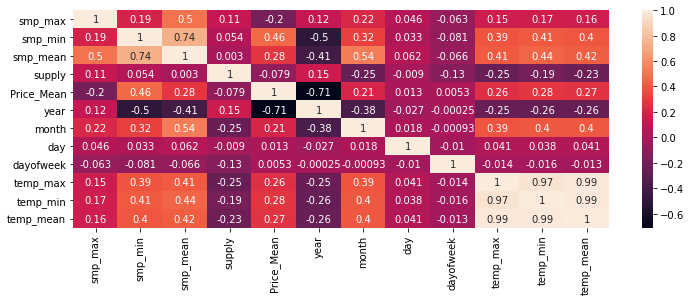

In [0]:
sns.heatmap(target.corr(), annot=True)

## 모델 학습 및 검정

In [0]:
def create_model(train, val):
    params = {
        'metric': 'mae',
        'seed':7777
        }

    model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
    
    # plt.rcParams['figure.figsize'] = [6, 4]
    # plt.plot(np.array(y_val), '.-', label='y_val')
    # plt.plot(model.predict(x_val), '.-', label='y_pred')
    # plt.title(str(future)+'days later')
    # plt.legend()
    # plt.show()

    model.predict(x_val)
    print(str(future) + 'days later~')
    return model



In [0]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    #future일 후 예측 (7일 ~ 34일) 
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index + past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future):
        indices = np.array(dataset.loc[i-past:i, x_columns])
        data.append(indices)
        
        labels.append(np.array(dataset.loc[i+future, y_columns]))
        
    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [0]:
past = 29 # 최근 30일 정보를 이용하여 n일 후를 예측

In [0]:
x_columns = ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']
y_columns = ['supply']
supply_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    supply_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[35]	valid_0's l1: 3.37013
7days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[90]	valid_0's l1: 3.65347
8days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[54]	valid_0's l1: 4.16792
9days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[35]	valid_0's l1: 4.37341
10days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[34]	valid_0's l1: 4.70251
11days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[204]	valid_0's l1: 4.0814
12days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's l1: 4.39813
13days later~
Training until validation scor

In [0]:
x_columns = ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']
y_columns = ['temp_max']
temp_max_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_max_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

####################################################


y_columns = ['temp_min']
temp_min_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_min_models[future] = create_model(d_train, d_val)
    print('==========================================================================')


####################################################

y_columns = ['temp_mean']
temp_mean_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_mean_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[6]	valid_0's l1: 1.93806
7days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[15]	valid_0's l1: 1.88958
8days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[17]	valid_0's l1: 1.84869
9days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[21]	valid_0's l1: 1.86814
10days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4]	valid_0's l1: 1.88072
11days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[7]	valid_0's l1: 2.05935
12days later~
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[6]	valid_0's l1: 1.99617
13days later~
Training until validation scores d

In [0]:
def create_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = lgb.Dataset(x_train, y_train)
        d_val = lgb.Dataset(x_val, y_val)

        params = {
            'metric': 'mse',
            'seed':777
            }

        model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
        
        # plt.rcParams['figure.figsize'] = [12, 4]
        # plt.plot(np.array(y_val), '.-', label='y_val')
        # plt.plot(model.predict(x_val), '.-', label='y_pred')
        # plt.legend()
        # plt.show()
        model.predict(x_val)
        models.append(model)

    return models

In [0]:
x_test = np.array(target.loc[700:, ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)
supply_result=[]
for future in range(7, 35):
    supply_result.append(supply_models[future].predict(x_test))
supply_result = np.array(supply_result).reshape(-1)
x_test = np.array(target.loc[700:, ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)
temp_max_result=[]
for future in range(7, 35):
    temp_max_result.append(temp_max_models[future].predict(x_test))
temp_max_result = np.array(temp_max_result).reshape(-1)
temp_min_result=[]
for future in range(7, 35):
    temp_min_result.append(temp_min_models[future].predict(x_test))
temp_min_result = np.array(temp_min_result).reshape(-1)
temp_mean_result=[]
for future in range(7, 35):
    temp_mean_result.append(temp_mean_models[future].predict(x_test))
temp_mean_result = np.array(temp_mean_result).reshape(-1)
submission = pd.read_csv('data/sample_submission.csv')
submission_bottom_half = submission.loc[28:,:]
submission = submission.loc[:27, :]
test = submission.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['supply'] = np.array(supply_result).reshape(-1)
test['temp_max'] = np.array(temp_max_result).reshape(-1)
test['temp_min'] = np.array(temp_min_result).reshape(-1)
test['temp_mean'] = np.array(temp_mean_result).reshape(-1)
test.head()

,date,smp_max,smp_min,smp_mean,supply,year,month,day,dayofweek,temp_max,temp_min,temp_mean
0,2020-02-07,0,0,0,84.399082,2020,2,7,4,14.327784,6.544510,11.204229
1,2020-02-08,0,0,0,84.127532,2020,2,8,5,10.937417,8.568800,7.786363
2,2020-02-09,0,0,0,81.156081,2020,2,9,6,11.783976,5.919198,11.905126
3,2020-02-10,0,0,0,82.382302,2020,2,10,0,12.847430,6.456685,13.013961
4,2020-02-11,0,0,0,77.843157,2020,2,11,1,16.836829,7.027671,11.784237


* SMP

In [0]:
x_train = target.loc[:, ['supply', 'year', 'month', 'day', 'dayofweek', 'Price_Median']]
# x_train = target.loc[:, ['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean','Price_Median']]
y_train = target.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]

smp_models = {}
for label in y_train.columns:
    print('train column : ', label)
    smp_models[label] = create_model(x_train, y_train[label])
    print('==========================================================================')

### Test 데이터에 Oil 값 추가 

In [0]:
test.tail()

In [0]:
test = pd.merge(test, daily_oil, how = 'outer')
test

In [0]:
x_test = test.loc[:,['supply', 'year', 'month', 'day', 'dayofweek','Price_Median']]
# x_test = test.loc[:,['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean','Price_Median']]
for label in  ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    for i in range(5): 
        preds.append(smp_models[label][i].predict(x_test))
    pred = sum(preds)/len(preds)
    test[label] = pred

In [0]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]
submission = pd.concat([submission, submission_bottom_half], axis = 0)
submission

In [0]:
submission.to_csv('submission_200520_v0.csv', index = False) 

In [0]:
sub = pd.read_csv('submission_200520_v0.csv')
sub